In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Tuple
from utils import is_left, segment_intersect, get_intersection, remove_zero_length_segments

# Raw Results

In [2]:
def check_crossing_raw(
    doorline: List[Tuple[float]],
    trace: List[Tuple[float]],
    max_count_for_single_trace: Optional[int] = 1,
    left_in: bool = True,
    return_intersections: bool = False,
) -> Tuple[int, int]:
    in_count = 0
    out_count = 0

    intersecting_directions, intersections = [], []
    for i in range(len(trace) - 1):
        for j in range(len(doorline) - 1): 
            if segment_intersect(doorline[j], doorline[j + 1], trace[i], trace[i + 1]):
                direction = is_left(doorline[j], doorline[j + 1], trace[i + 1])
                intersecting_directions.append(direction)
                if return_intersections:
                    this_intersection = get_intersection(doorline[j], doorline[j + 1], trace[i], trace[i + 1])
                    intersections.append(this_intersection)

    # assuming left is in and right is out
    in_count = sum(direction for direction in intersecting_directions if direction)
    out_count = len(intersecting_directions) - in_count
    if not left_in:
        in_count, out_count = out_count, in_count

    if max_count_for_single_trace is None:
        headcounts = (in_count, out_count)
    else:
        if in_count > out_count:
            max_count_for_single_trace = min(max_count_for_single_trace, in_count)
            headcounts = (max_count_for_single_trace, max_count_for_single_trace - 1)
        elif in_count == out_count:
            max_count_for_single_trace = min(max_count_for_single_trace, in_count)
            headcounts = (max_count_for_single_trace, max_count_for_single_trace)
        else:
            max_count_for_single_trace = min(max_count_for_single_trace, out_count)
            headcounts = (max_count_for_single_trace - 1, max_count_for_single_trace)
    if not return_intersections:
        return headcounts
    else:
        return (headcounts, intersections)

In [3]:
trace = [
     [0.0, 0.5375],
     [0.0625, 0.5625],
     [0.0625, 0.5],
     [0.13690476190476192, 0.511904761904762],
     [0.13690476190476192, 0.511904761904762],
     [0.2619047619047619, 0.511904761904762],
     [0.3125, 0.625],
     [0.3630952380952381, 0.613095238095238],
     [0.375, 0.625],
     [0.5, 0.625],
     [0.5, 0.625],
     [0.5625, 0.6875],
     [0.625, 0.6875],
     [0.613095238095238, 0.738095238095238],
     [0.625, 0.75],
     [0.613095238095238, 0.761904761904762],
     [0.613095238095238, 0.761904761904762],
     [0.6875, 0.8125],
     [0.6875, 0.8125],
     [0.6875, 0.8125],
     [0.6875, 0.875],
     [0.6875, 0.875],
     [0.6875, 0.875],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.75, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.6875, 0.9375],
     [0.8125, 0.9375],
]
doorline = [[0.25, 0.01], [0.625, 0.375], [0.625, 0.75], [0.188, 0.99]]

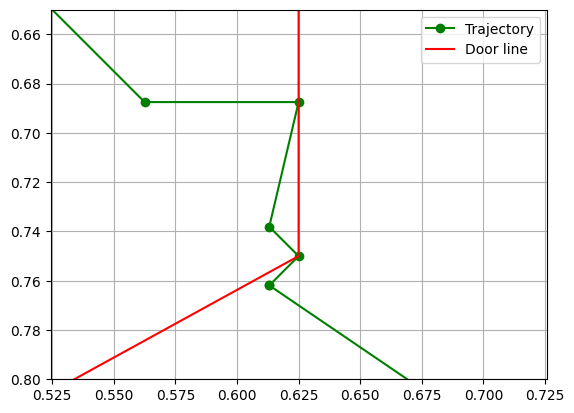

In [4]:
fig, ax = plt.subplots()
ax.plot(np.array(trace)[:,0], np.array(trace)[:,1], 'g-o', label="Trajectory")
ax.plot(np.array(doorline)[:,0],np.array(doorline)[:,1], "r-", label="Door line")

ax.grid("on")
ax.axis("equal")
ax.set_xlim(0.55, 0.70)
ax.set_ylim(0.65, 0.80)

ax.invert_yaxis()
ax.legend()

In [5]:
print("in_out: ", check_crossing_raw(doorline, trace))

in_out:  (1, 1)


# Method 1: Check inital and final status of indoors/outdoors

For trace A-B-C and door line D-B-E, we check if the initial point A is indoors or outdoors, and then check if the final point C is indoors or outdoors.  
Only A and C has the different status, i.e, A is indoors and C is outdoors, or vice versa, then A-B-C vs. D-B-E will make a in- or out- headcount.  

Once we have checked A-B-C and D-B-E, we do not to check this 2-trace-segment vs. 2-doorline-segment intersection again.

There are several other possibilities:
- A-B-C vs. D-B-E: most important case
- A-B-C vs. B-D-E: the door line starts from the common node B
- A-C-B vs. D-B-E / B-D-E: the trace ends at the common node B
- B-A-C vs. D-B-E / B-D-E: the trace starts from the common node B


In [6]:
def check_crossing_new(
    doorline: List[Tuple[float]],
    trace: List[Tuple[float]],
    max_count_for_single_trace: Optional[int] = 1,
    left_in: bool = True,
    return_intersections: bool = False,
) -> Tuple[int, int]:
    in_count = 0
    out_count = 0
    intersecting_directions, intersections = [], []
    skip_common_nodes = {}
    doorline = [tuple(p) for p in doorline]
    trace = [tuple(p) for p in trace]
    for i in range(len(trace) - 1):
        for j in range(len(doorline) - 1):  
            common_nodes = [p for p in trace[i: i+2] if p in doorline[j: j+2]]
            
            new_common_node = len(common_nodes) > 0
            if len(common_nodes):
                for cn in common_nodes:
                    if cn not in skip_common_nodes:
                        skip_common_nodes.update({
                            cn: {
                                "trace_idx": [i, trace.index(cn)],
                                "door_line_idx": [j, doorline.index(cn)],
                            }
                        })
                    else:
                        skip_index = skip_common_nodes[cn]
                        if i in skip_index["trace_idx"] and i in skip_index["door_line_idx"]:
                            new_common_node = False
                            break
            if new_common_node:
                skip_next_for_common_node = True
                if trace[i+1] == doorline[j+1] and i+2 < len(trace):  # trace=ABC, doorline=DBE 
                    init_status = is_left(doorline[j], doorline[j+1], trace[i]) and (
                        j+2 >= len(doorline) or is_left(doorline[j+1], doorline[j+2], trace[i])
                    )
                    final_status = is_left(doorline[j], doorline[j+1], trace[i+2]) and (
                        j+2 >= len(doorline) or is_left(doorline[j+1], doorline[j+2], trace[i+2]) 
                    )
                    this_intersection = doorline[j+1]
                elif trace[i+1] == doorline[j] and i+2 < len(trace):  # trace=ABC, doorline=BDE
                    init_status = is_left(doorline[j], doorline[j+1], trace[i])
                    final_status = is_left(doorline[j], doorline[j+1], trace[i+2])
                    this_intersection = doorline[j]
                # elif trace[i] == doorline[j+1]: # trace=BAC, doorline=DBE
                #     init_status = final_stats = is_left(doorline[j], doorline[j+1], trace[i+1]) and is_left(doorline[j+1], doorline[j+2], trace[i+1]) 
                # elif trace[i] == doorline[j]:   # trace=BAC, doorline=BDE
                #     init_status = final_stats = is_left(doorline[j], doorline[j+1], trace[i+1])
                else:
                    # in all other cases, the trace starts or ends with a node in the doorline, we can assume it does not lead to a change in occupancy
                    init_status = final_status = True   

                if init_status != final_status:
                    intersecting_directions.append(final_status)
                    if return_intersections:
                        intersections.append(this_intersection)
            if len(common_nodes)==0 and segment_intersect(doorline[j], doorline[j + 1], trace[i], trace[i + 1]):
                direction = is_left(doorline[j], doorline[j + 1], trace[i + 1])
                intersecting_directions.append(direction)
                if return_intersections:
                    this_intersection = get_intersection(doorline[j], doorline[j + 1], trace[i], trace[i + 1])
                    intersections.append(this_intersection)

    # assuming left is in and right is out
    in_count = sum(direction for direction in intersecting_directions if direction)
    out_count = len(intersecting_directions) - in_count
    if not left_in:
        in_count, out_count = out_count, in_count

    if max_count_for_single_trace is None:
        headcounts = (in_count, out_count)
    else:
        if in_count > out_count:
            max_count_for_single_trace = min(max_count_for_single_trace, in_count)
            headcounts = (max_count_for_single_trace, max_count_for_single_trace - 1)
        elif in_count == out_count:
            max_count_for_single_trace = min(max_count_for_single_trace, in_count)
            headcounts = (max_count_for_single_trace, max_count_for_single_trace)
        else:
            max_count_for_single_trace = min(max_count_for_single_trace, out_count)
            headcounts = (max_count_for_single_trace - 1, max_count_for_single_trace)
    if not return_intersections:
        return headcounts
    else:
        return (headcounts, intersections)

In [7]:
print("in_out: ", check_crossing_new(doorline, trace))

in_out:  (0, 1)


# Method 2: Use AC instead of A-B-C when B is the common node

In [8]:
def remove_common_nodes(trace, doorline):
    modified_trace = [trace[0]]
    for i in range(1, len(trace) - 1):
        if trace[i] not in doorline:
            modified_trace.append(trace[i])
    modified_trace.append(trace[-1])
    return modified_trace

in_out:  (0, 1)


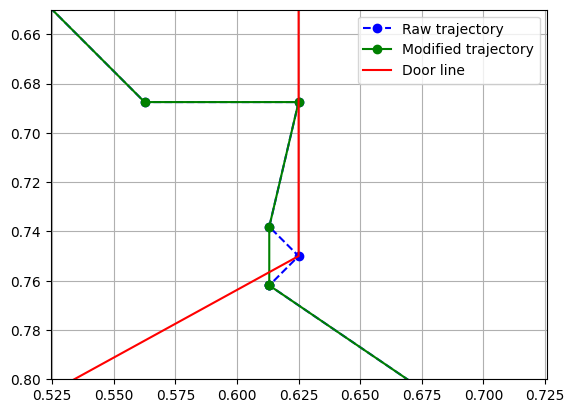

In [9]:
modified_trace = remove_common_nodes(trace, doorline)
print("in_out: ", check_crossing_raw(doorline, modified_trace))

fig, ax = plt.subplots()
ax.plot(np.array(trace)[:,0], np.array(trace)[:,1], 'b--o', label="Raw trajectory")
ax.plot(np.array(modified_trace)[:,0], np.array(modified_trace)[:,1], 'g-o', label="Modified trajectory")
ax.plot(np.array(doorline)[:,0],np.array(doorline)[:,1], "r-", label="Door line")

ax.grid("on")
ax.axis("equal")
ax.set_xlim(0.55, 0.70)
ax.set_ylim(0.65, 0.80)

ax.invert_yaxis()
ax.legend()

# Method 3: Move the point slightly to avoid common node

In [10]:
import random

def generate_nearby_point(x, y, offset_range=1e-6):
    dx = (random.random() - 0.5) * offset_range
    dy = (random.random() - 0.5) * offset_range
    return (x + dx, y + dy)

def move_common_nodes_slightly(trace, doorline):
    modified_trace = [trace[0]]
    for i in range(1, len(trace) - 1):
        if trace[i] not in doorline:
            modified_trace.append(trace[i])
        else:
            modified_trace.append(generate_nearby_point(trace[i][0], trace[i][1]))
    modified_trace.append(trace[-1])
    return modified_trace

in_out:  (0, 1)


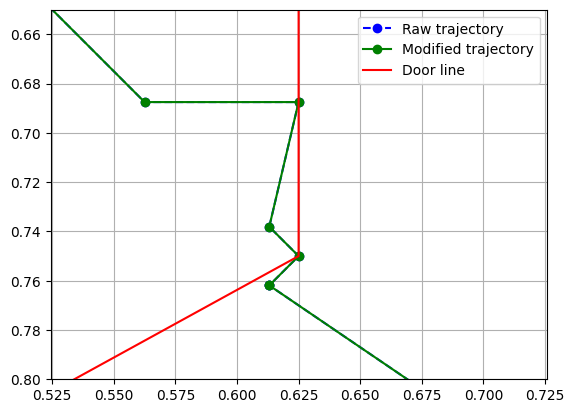

In [11]:
modified_trace2 = move_common_nodes_slightly(trace, doorline)
print("in_out: ", check_crossing_raw(doorline, modified_trace))

fig, ax = plt.subplots()
ax.plot(np.array(trace)[:,0], np.array(trace)[:,1], 'b--o', label="Raw trajectory")
ax.plot(np.array(modified_trace2)[:,0], np.array(modified_trace2)[:,1], 'g-o', label="Modified trajectory")
ax.plot(np.array(doorline)[:,0],np.array(doorline)[:,1], "r-", label="Door line")

ax.grid("on")
ax.axis("equal")
ax.set_xlim(0.55, 0.70)
ax.set_ylim(0.65, 0.80)

ax.invert_yaxis()
ax.legend()